## Data Loading

In [17]:
from azure.storage.filedatalake import DataLakeServiceClient

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv('notebooks/corrected/.env')

# Replace with your details
storage_account_name = "mldebugdevadls"
storage_account_key = os.getenv('AZURE_STORAGE_KEY')

# Connect to ADLS
service_client = DataLakeServiceClient(
    account_url=f"https://{storage_account_name}.dfs.core.windows.net",
    credential=storage_account_key,
    api_version="2023-11-03"  # Use the correct supported API version
)

# List Containers
containers = service_client.list_file_systems()
for container in containers:
    print(container.name)


data


In [18]:
# Replace with your details
container_name = "data"

In [19]:
import os
from azure.storage.blob import BlobServiceClient
import pandas as pd
import io

def read_csv_from_blob(storage_account_name, container_name, file_name, storage_account_key=None):
    """
    Read a CSV file from Azure Blob Storage using Python and return a Pandas DataFrame.

    :param storage_account_name: Azure storage account name.
    :param container_name: Blob container name.
    :param file_name: Name of the file in the container.
    :param storage_account_key: Storage account access key.
    :return: Pandas DataFrame.
    """
    
    if not storage_account_key:
        # Try to get the key from environment variables if not provided
        storage_account_key = os.environ.get('AZURE_STORAGE_KEY')
        
    if not storage_account_key:
        raise ValueError("Storage account key must be provided either as a parameter or as an environment variable 'AZURE_STORAGE_KEY'")
    
    try:
        # Create a connection string
        connection_string = f"DefaultEndpointsProtocol=https;AccountName={storage_account_name};AccountKey={storage_account_key};EndpointSuffix=core.windows.net"
        
        # Create the BlobServiceClient
        blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        
        # Get the container client
        container_client = blob_service_client.get_container_client(container_name)
        
        # Get the blob client
        blob_client = container_client.get_blob_client(file_name)
        
        # Download the blob content
        download_stream = blob_client.download_blob()
        
        # Convert the content to a DataFrame
        content = download_stream.readall()
        df = pd.read_csv(io.BytesIO(content))
        
        return df
    
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

In [20]:
online_marketing = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="OnlineMarketingData.csv",
                                      storage_account_key=storage_account_key)
offline_marketing = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="OfflineMarketingData.csv",
                                      storage_account_key=storage_account_key)
sales = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="SalesData.csv",
                                      storage_account_key=storage_account_key)
price = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="PricingData.csv",
                                      storage_account_key=storage_account_key)

## Importing libraries 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [22]:
sales_data = sales.copy()
offline_data = offline_marketing.copy()
digital_data = online_marketing.copy()

In [23]:
# Read sales data and convert to date to datetime
sales_data['date'] =  pd.to_datetime(sales_data['date'])

#read offline marketing data and convert week to datetime
offline_data['week'] = pd.to_datetime(offline_data['week'])

#read online marketing data and convert to datetime
digital_data['date'] = pd.to_datetime(digital_data['date'])


In [24]:
sales_data

,date,city,state,store_id,product_id,sales_quantity
0,2023-01-01,Mumbai,Maharashtra,MUM_01,P001,112
1,2023-01-01,Mumbai,Maharashtra,MUM_01,P002,100
2,2023-01-01,Mumbai,Maharashtra,MUM_01,P003,126
3,2023-01-01,Mumbai,Maharashtra,MUM_01,P004,108
4,2023-01-01,Mumbai,Maharashtra,MUM_01,P005,129
...,...,...,...,...,...,...
554795,2023-12-31,Guwahati,Assam,GUW_05,P004,71
554796,2023-12-31,Guwahati,Assam,GUW_05,P005,100
554797,2023-12-31,Guwahati,Assam,GUW_05,P006,96
554798,2023-12-31,Guwahati,Assam,GUW_05,P007,136


## Task 1: Time Series Visualization with Misaligned Time Frequencies and Scale Differences

In [12]:
# Calculate total daily sales to match with marketing data
daily_sales = sales_data.groupby('date')['sales_quantity'].sum().reset_index()
daily_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)

In [13]:
# Merge digital data with daily sales for analysis
digital_sales = pd.merge(digital_data, daily_sales, on='date', how='left')

In [14]:
# Aggregate weekly sales for comparison with weekly media spend
weekly_sales = daily_sales.copy()
weekly_sales['week'] = pd.to_datetime(weekly_sales['date']).dt.to_period('W').dt.start_time
weekly_sales = weekly_sales.groupby('week')['total_sales'].sum().reset_index()

In [15]:
# Merge weekly media spend with weekly sales
media_sales = pd.merge(offline_data, weekly_sales, on='week', how='left')

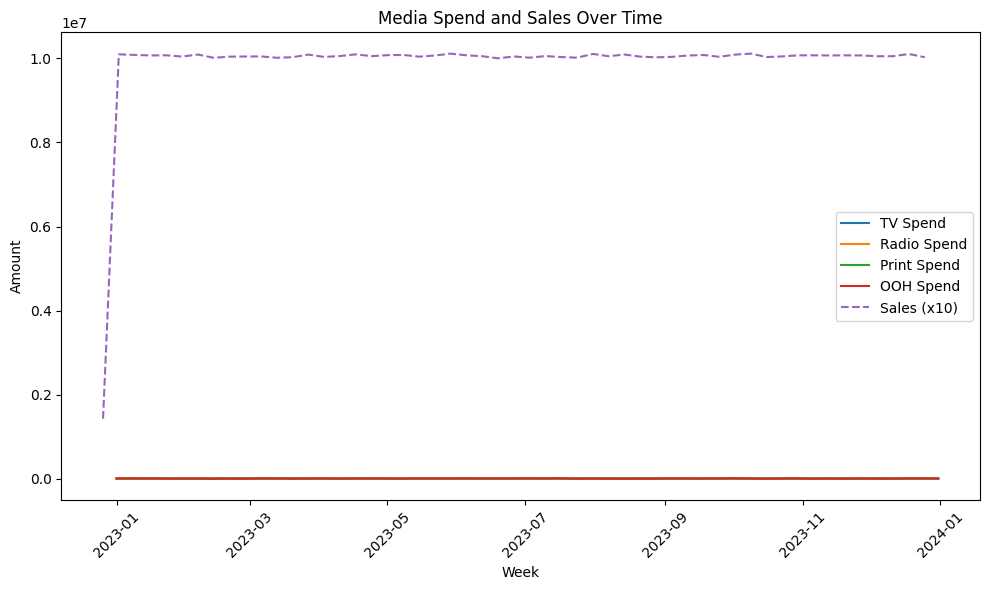

In [16]:
def plot_buggy_time_series():
    # Pivot the media data to have channels as columns
    offline_data_pivoted = offline_data.pivot_table(index='week', columns='channel', values='spend', aggfunc='sum')

    # Plot the media spend and sales over time
    plt.figure(figsize=(10, 6))
    plt.plot(offline_data_pivoted.index, offline_data_pivoted['TV'], label='TV Spend')
    plt.plot(offline_data_pivoted.index, offline_data_pivoted['Radio'], label='Radio Spend')
    plt.plot(offline_data_pivoted.index, offline_data_pivoted['Print'], label='Print Spend')
    plt.plot(offline_data_pivoted.index, offline_data_pivoted['OOH'], label='OOH Spend')

    # Sales data with arbitrary scaling
    plt.plot(weekly_sales['week'], weekly_sales['total_sales'] * 10, label='Sales (x10)', linestyle='--')

    # Add titles and labels
    plt.title('Media Spend and Sales Over Time')
    plt.xlabel('Week')
    plt.ylabel('Amount')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_buggy_time_series()

## Task 2: Incorrect Correlation Analysis with Mixed Frequency Data

In [0]:
# Pivot the media data to have channels as columns
offline_data_pivoted = offline_data.pivot_table(index='week', columns='channel', values='spend', aggfunc='sum')

# Align with the digital data (ensure we match by the correct index)
# Assuming digital_data has 'date' and 'clicks', we can group by date and align with weeks if necessary
clicks_data = digital_data.groupby('date')['clicks'].sum().head(6).values  # Ensure it’s aligned by date

In [0]:
def plot_buggy_correlation():
    # Convert the media data to daily frequency by assuming spend is constant within the week
    media_spend_daily = offline_data.copy()

    # We assume each week's spend is repeated for each day of the week
    media_spend_daily = media_spend_daily.loc[media_spend_daily['channel'] == 'TV', ['week', 'spend']]
    media_spend_daily['date'] = pd.to_datetime(media_spend_daily['week'])
    media_spend_daily = media_spend_daily.set_index('date').resample('D').ffill()  # Resample to daily with forward fill

    # Merge datasets (now aligned by daily date)
    merged_data = pd.merge(media_spend_daily[['spend']], digital_data[['date', 'channel', 'clicks']],
                           left_index=True, right_on='date', how='inner')

    # Now create the correct correlation DataFrame for the merged data
    corr_data = merged_data.pivot_table(index='date', columns='channel', values='spend', aggfunc='sum')
    corr_data['Clicks'] = merged_data.groupby('date')['clicks'].sum()

    # Plot the correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm')
    plt.title('Corrected Correlation Heatmap (Aligned Data)')
    plt.tight_layout()
    plt.show()

# # Call the function to demonstrate the corrected plot
plot_buggy_correlation()


## Task 3: Misleading Seasonality Analysis

In [0]:
def plot_buggy_seasonality():
    # Resample sales to weekly for analysis - but choose wrong frequency
    weekly_sales = daily_sales.copy()
    weekly_sales.set_index('date', inplace=True)
    weekly_sales = weekly_sales.resample('W').sum().reset_index()  # Using week ending Sunday

    # Attempt decomposition without proper time series formatting
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_sales['date'], weekly_sales['total_sales'])

    # Add arbitrary seasonal lines without statistical basis
    seasonal_pattern = np.sin(np.linspace(0, 4*np.pi, len(weekly_sales))) * 50 + 150
    plt.plot(weekly_sales['date'], seasonal_pattern, 'r--', label='Assumed Seasonality')

    plt.title('Buggy Seasonality Analysis')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Task 4: Incorrect Assessment of Advertising Efficiency

In [0]:
# ----------------------------
# BUGGY PLOT 4: Incorrect assessment of advertising efficiency
# ----------------------------

def plot_buggy_efficiency():
    # Calculate Cost Per Click without considering channel differences
    digital_data['cpc'] = digital_data['spend'] / digital_data['clicks']

    # Simple bar chart without context
    plt.figure(figsize=(10, 6))
    sns.barplot(x='channel', y='cpc', data=digital_data)
    plt.title('Cost Per Click by Channel')
    plt.xlabel('Channel')
    plt.ylabel('CPC ($)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()